# Reading Decisions

This is a notebook experimenting with reading decision datasets.  
The the following dataset can be found at:
[https://zenodo.org/record/3911068#.X60JqS-ZPUo](https://zenodo.org/record/3911068#.X60JqS-ZPUo)

In [16]:
import re
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.core.display import HTML
plt.style.reload_library()
plt.style.use(['science'])

In [2]:
import patterns

In [3]:
plt.rcParams.update({'font.size': 16})

In [4]:
df = pd.read_csv('2020_06_23_CE-BVerwG_DE_Datensatz.csv')

## Accessing decision texts

In [5]:
example_decision_text = df['text'][0]
example_decision_text[:1000]

'BUNDESVERWALTUNGSGERICHT\nIM NAMEN DES VOLKES\nURTEIL\nBVerwG 6 C 3.96\nOVG 10 L 5059/93\n\nVerkündet\nam 26. Februar 1997\nCremer\nJustizhauptsekretär\nals Urkundsbeamter der Geschäftsstelle\n\nIn der Verwaltungsstreitsache\n\n\x0c- 2 -\n\nhat der 6. Senat des Bundesverwaltungsgerichts\nauf die mündliche Verhandlung vom 26. Februar 1997\ndurch die Richter\nDr. S e i b e r t ,\nA l b e r s ,\nDr. V o g e l g e s a n g ,\ndie Richterin\nE c k e r t z - H ö f e r\nund den Richter\nDr.\nS c h m u t z l e r\nfür Recht erkannt:\nDie Revision der Beigeladenen gegen das Urteil\ndes Niedersächsischen Oberverwaltungsgerichts\nvom 19. Dezember 1995 wird mit der Maßgabe zurückgewiesen, daß der Beklagte die erstinstanzlich ausgesprochene Verpflichtung auch in der\nWeise erfüllen kann, daß er der Klägerin neben\nden dort genannten Entscheidungen auch alle anderen als veröffentlichungswürdig ausgewählten\noder als solche anerkannten und mit einer neutralisierten Fassung versehenen Entscheidungen\nd

## Counting occurrences
In this example the occurrences of “VwGO” in all decisions is counted:

In [6]:
search = r'VwGO'

count = 0
for decision in tqdm(df['text']):
    count += len(re.findall(search, decision))
print('Count (“%s“): ' % search, count)

100%|██████████| 24224/24224 [00:00<00:00, 45916.45it/s]

Count (“VwGO“):  136807


In [7]:
re.findall(r'§.*VwGO', example_decision_text)

['§ 65 Abs. 2 VwGO', '§ 55 VwGO', '§ 154 VwGO']

## Find references

In the following section some functions are defined to find references in text and convert them to a uniform style:

In [8]:
hierarchy = {
    'section': '§ %d ',
    'paragraph': 'Abs. %d ',
    'clause': 'S. %d',
}

def str_int(string: str) -> int:
    if string == '':
        return None
    else:
        return int(string)
    
def reference_to_str(reference_dict: dict, level: int = None, book: str = '') -> str:
    result = ''
    book = ' ' + book.strip()
    n = 0
    for key, expression in hierarchy.items():
        value = reference_dict[key]
        if value is not None and (level is None or n <= level):
            result += expression %  value
        n += 1
    result = result.strip() + book
    result = result.strip()
    return result

def find_references(decision_text: str, book: str) -> list:
    references = re.findall(r'§ (\d+)\W*[Abs.]*\W*(\d+)*\W*[S.]*\W*(\d+)*\W*' + book, decision_text.replace('\n', ''))
    references = [{'book': book,'section': str_int(m[0]), 'paragraph': str_int(m[1]), 'clause': str_int(m[2])} for m in references]
    return references

In [9]:
references = find_references(example_decision_text.replace('\n', ''), 'VwGO')
references

[{'book': 'VwGO', 'section': 65, 'paragraph': 2, 'clause': None},
 {'book': 'VwGO', 'section': 55, 'paragraph': None, 'clause': None},
 {'book': 'VwGO', 'section': 154, 'paragraph': 2, 'clause': None},
 {'book': 'VwGO', 'section': 154, 'paragraph': None, 'clause': None}]

## Find most common occurrences
The variable level is setting the hierarchy depth.

In [10]:
level = 0
counter = collections.Counter()

for decision in tqdm(df['text']):
    references = find_references(decision, patterns.book_matching)
    for reference in references:
        reference_str = reference_to_str(reference, level=level)
        counter[reference_str] += 1
        
counter.most_common(30)

100%|██████████| 24224/24224 [00:29<00:00, 808.67it/s] 


[('§ 132', 32096),
 ('§ 1', 27379),
 ('§ 2', 17237),
 ('§ 154', 16459),
 ('§ 3', 15633),
 ('§ 133', 14869),
 ('§ 4', 13107),
 ('§ 47', 11746),
 ('§ 6', 11128),
 ('§ 5', 11125),
 ('§ 52', 10912),
 ('§ 13', 9982),
 ('§ 17', 8595),
 ('§ 9', 8450),
 ('§ 7', 8194),
 ('§ 108', 7979),
 ('§ 86', 7970),
 ('§ 8', 7784),
 ('§ 10', 7620),
 ('§ 137', 6651),
 ('§ 11', 6249),
 ('§ 14', 6143),
 ('§ 15', 6129),
 ('§ 12', 5931),
 ('§ 60', 5433),
 ('§ 35', 5024),
 ('§ 21', 4868),
 ('§ 20', 4025),
 ('§ 99', 3825),
 ('§ 18', 3812)]

(array([126.,  44.,  17.,  16.,  11.,   9.,   4.,   5.,   5.,   3.]),
 array([ 10.,  29.,  48.,  67.,  86., 105., 124., 143., 162., 181., 200.]),
 <BarContainer object of 10 artists>)

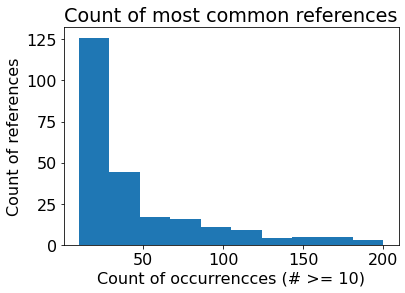

In [11]:
plt.title('Count of most common references')
plt.xlabel('Count of occurrencces (# >= 10)')
plt.ylabel('Count of references')
plt.hist([count for reference, count in counter.items()], range=[10, 200])

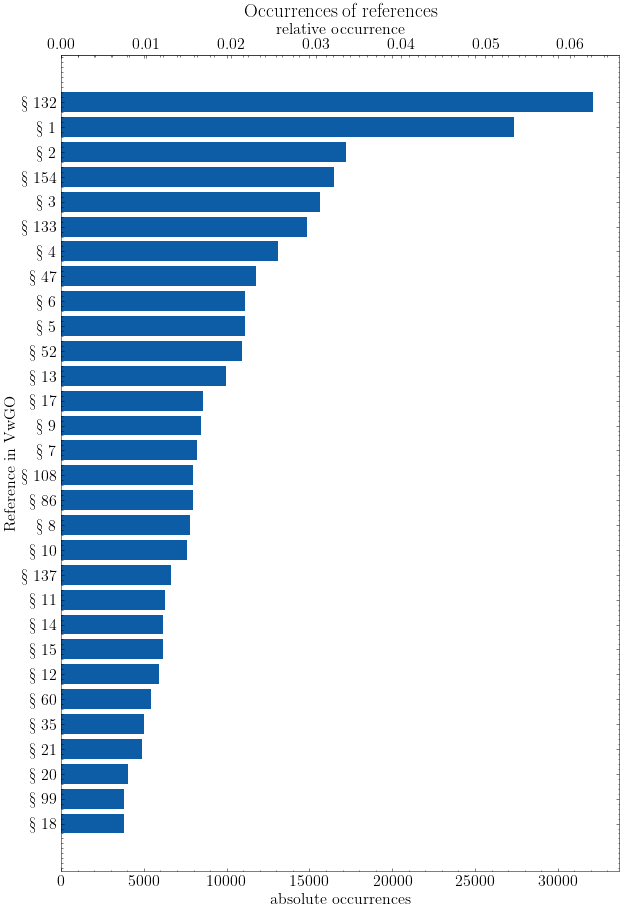

In [22]:
fig, ax = plt.subplots(figsize=(10,15))
count_all_references = sum(counter.values())
counts = [count for reference, count in counter.most_common(30)]
references = [reference for reference, count in counter.most_common(30)]

y_pos = np.arange(len(references))
ax.barh(y_pos, counts, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(references)
secax = ax.secondary_xaxis('top', functions=(lambda x: x/count_all_references,lambda x: x))
secax.set_xlabel('relative occurrence')
ax.invert_yaxis()
ax.set_xlabel('absolute occurrences')
ax.set_ylabel('Reference in VwGO')
ax.set_title('Occurrences of references')

fig.savefig('occurrences.png')

In [13]:
def prepare_text(text: str) -> str:
    abk = {
        'z\.B\.': 'zB',
        'Nr\.': 'Nr',
        
    }
    
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'Abs.', 'Abs', text) # Absätze
    text = re.sub(r'S\.', 'S', text) # Sätze
    text = re.sub(r'HS\.', 'HS', text) # Hauptsatz
    text = re.sub(r'Art\.', 'Art', text) # Artikel    
    text = re.sub(r'Nr\.', 'Nr', text) # Artikel    
    text = re.sub(r'\d{1,2}\. \w+ \d{4}', '_', text) # Datum
    text = re.sub(r'\d{1,2}\.\d{2}\.\d{4}', '_', text) # Datum
    
    for k, v in abk.items():
        text = re.sub(k, v, text) # Abkürzungen    
    return text

HTML('<table><tr><td style="text-align: left">Unprocessed</td><td>Processed</td></tr><tr><td style="text-align: left">%s</td><td style="text-align: left">%s</td></tr></table>' % (example_decision_text.replace('\n', '<br>'), prepare_text(example_decision_text.replace('\n', '<br>'))))

Unprocessed,Processed


In [14]:
result = []

for decision in tqdm(df['text'][:10]):
    prepared = prepare_text(decision)
    for line in prepared.replace(':', '.').split('.'):
        line_references = find_references(line, '')
        if len(line_references) == 1:
            result.append(
                {
                    'section': line_references[0]['section'],
                    'line': line,
                }
            )
result

100%|██████████| 10/10 [00:00<00:00, 404.55it/s]


[{'section': 42,
  'line': ' Die den Richtern gegenüber tatsächlich und rechtlich (§ 42 DRiG) durchsetzbare Mitwirkungspflicht umfasse die Anzeige veröffentlichungswürdiger Entscheidungen'},
 {'section': 5,
  'line': ' Die fehlerhafte Begründung, Gerichtsentscheidungen stünden in der ausschließlichen Verfügungsgewalt der Gerichtsverwaltung, verstoße zugleich auch gegen § 5 UrhG'},
 {'section': 65,
  'line': ' Ein Fall der notwendigen Beiladung nach § 65 Abs 2 VwGO, die gegebenenfalls im Revisionsverfahren nachzuholen wäre, liegt nicht vor'},
 {'section': 12, 'line': ' 1994, § 12 Rdnr'},
 {'section': 132, 'line': ' auch § 132 Abs 4 GVG)'},
 {'section': 5,
  'line': ' Mit Recht hat das Berufungsgericht in diesem Zusammenhang auch auf § 5 Abs 1 UrhG hingewiesen'},
 {'section': 55, 'line': ' § 55 VwGO i'},
 {'section': 169,
  'line': ' §§ 169, 173 GVG), geht aber über diesen - wie ausgeführt - hinaus'},
 {'section': 30,
  'line': ' Insbesondere die Wahrung der Persönlichkeitsrechte der Ver

In [15]:
sectionized = [[y for y in result if y['section'] == s] for s in sorted(list(set([x['section'] for x in result])))]